# Glucose three-strain tri-culture
Results from analysis of the tri-culture growing on glucose.
Consiting of constructs SAL9 (bl21 derived), CAL2 (k12 derived), and MAM2 (k12 derived).

This notebook contains key numbers from the experimental data, static steady-state analysis of relative community member abundance and theoretical max rosmarinic acid (RA) production rate, dynamic simulation and time-course growth and production profiles, and comparison of inoculation ratio and substrate composition.

## Loading and preparing models

In [1]:
from reframed import Community, Environment
from reframed import load_cbmodel

# load all models into reframed
CAL2 = load_cbmodel("GEMs/CAL2.xml", flavor="bigg")
SAL9 = load_cbmodel("GEMs/SAL9.xml", flavor="bigg")
MAM2 = load_cbmodel("GEMs/MAM2.xml", flavor="bigg")

# stop SAA module from looping by making the reactions one-way
SAL9.reactions.R_HPPHD.set_flux_bounds(0, float("inf"))
SAL9.reactions.R_DHPPSA.set_flux_bounds(0, float("inf"))
SAL9.reactions.R_DLDH.set_flux_bounds(float("-inf"), 0)
SAL9.reactions.R_HPLSA.set_flux_bounds(0, float("inf"))

In [2]:
# in order to equal the playing field between BL21 and K12 derived models:

# adjust the biomass reaction
SAL9.reactions.R_BIOMASS_Ec_iHK1487_core.stoichiometry["M_atp_c"] = -75.55223
SAL9.reactions.R_BIOMASS_Ec_iHK1487_core.stoichiometry["M_h_c"] = 75.377230
SAL9.reactions.R_BIOMASS_Ec_iHK1487_core.stoichiometry["M_adp_c"] = 75.377230
SAL9.reactions.R_BIOMASS_Ec_iHK1487_core.stoichiometry["M_pi_c"] = 75.373230
SAL9.reactions.R_BIOMASS_Ec_iHK1487_core.stoichiometry["M_h2o_c"] = -70.028756

# adjust the ATP maintanance requrenment
SAL9.reactions.R_ATPM.lb = 6.86

In [3]:
# build community object
community = Community('RA_community', [CAL2, SAL9, MAM2])
merged_community = community.merge_models()

# get medium
medium = Environment.from_model(CAL2).apply(merged_community, exclusive=True, inplace=False)

## Experimental results

In [1]:
import pandas as pd
import functions.data_analysis as data_analysis

# read data
relative_abundance_df = pd.read_csv("exp_data/subpop_data_glc.csv")
products_df = pd.read_csv("exp_data/conc_data_glc.csv")
od600_df = pd.read_csv("exp_data/od600_glc.csv")

subpop_df, conc_df, OD_df = data_analysis.process_data(relative_abundance_df, products_df, od600_df)

growth_curves = data_analysis.get_growth_curves(OD_df, subpop_df, ["CAL2", "SAL9", "MAM2"])

In [2]:
cal2_ra, sal9_ra, mam2_ra = data_analysis.get_relative_abundance_stats_triculture_glc(subpop_df)

Relative SAl9 abundance at steady-state: 0.162477558
Relative CAL2 abundance at steady-state: 0.509874327
Relative MAM2 abundance at steady-state: 0.333034111


In [3]:
data_analysis.print_production_stats_triculture(conc_df)

Final RA concentration (mg/L): 102.067082
Final RA amount (mmol): 0.02832719666247404
Final SAA concentration (mg/L): 35.9831662
Final SAA amount (mmol): 0.0181574789060249
Final CA concentration (mg/L): 61.05309627
Final CA amount (mmol): 0.033888752984889886


In [4]:
CA_yield, SAA_yield, RA_yield = data_analysis.get_yields_glc(conc_df)

CA yield 0.04483465490800001 g CA per g glucose
SAA yield 0.11514992082541836 g SAA per g glucose
RA yield 0.06003946 g RA per g glucose


## Static simulation

### Theoretical RA production
using steadiercom

In [9]:
from reframed.community.simulation import simulate as SteadierCom

steadiercom_sim = SteadierCom(community, allocation=True, constraints=medium, objective="R_EX_rosma_e", w_e=0.002, w_r=0)
print("RA production rate: ", steadiercom_sim.values["R_EX_rosma_e"])
print(steadiercom_sim)

RA production rate:  2.3199316239469243
Community growth: 0.1
CAL2	0.7815907336980887
SAL9	0.08075896123235937
MAM2	0.13765030506955192


- SteadierCom scales the fluxes by the abundance of the species, and applies enzyme allocation constraints
- relative abundance between community member that follows the same pattern as exp. data (CAL2 > MAM2 > SAL9) when maximising RA production
- Steadiercom predicts a max theoretical RA production rate of 2.31

In [11]:
print("glucose uptake:", steadiercom_sim.values["R_EX_glc__D_e"])

print("RA yield per unit glucose uptake:", steadiercom_sim.values["R_EX_rosma_e"] / steadiercom_sim.values["R_GLCtex_copy2_MAM2"]) 

glucose uptake: -10.0
RA yield per unit glucose uptake: 5.190741316753938


### Relative species abundance

Using steadiercom:

In [12]:
from functions.steadiercom import SteadierComFVA
from tqdm.notebook import tqdm

results_list = []

for i in tqdm(range(950, 1005, 5)):
    frac = i/1000
    com_fva_solution = SteadierComFVA(community, constraints=medium, obj_frac=frac, allocation=True)
    com_fva_solution["frac"] = frac
    results_list.append(com_fva_solution)

results_df = pd.DataFrame(results_list);
results_df.set_index("frac");

  0%|          | 0/11 [00:00<?, ?it/s]

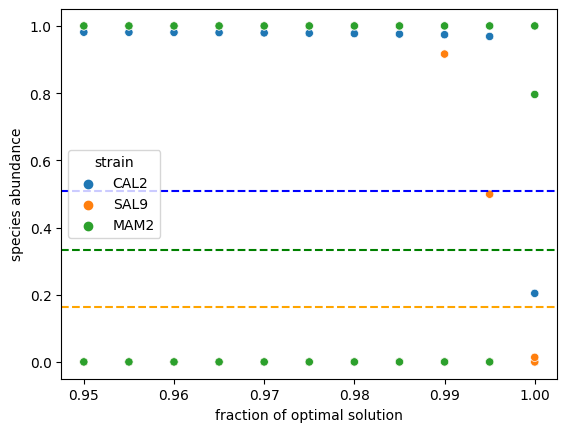

In [16]:
from functions.plot_results import plot_relative_abundance_glc

plot_relative_abundance_glc(results_df, cal2_ra, sal9_ra, mam2_ra, scatter=True)

- the solution space is very wide, but SAL9 (which is the slowest-growing strain) cannot be quite as abundant at high fractions of optimum
- the measured relative species abundance is within the FVA range at about 99.5% of optimum

In [12]:
from reframed.community.simulation import simulate as SteadierCom
from functions.steadiercom import SteadierComFVA
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

num_points = 11

steadiercom_sim = SteadierCom(community, allocation=True, constraints=medium, objective="R_EX_rosma_e")
max_RA = steadiercom_sim.values["R_EX_rosma_e"]

RA_vals = np.linspace(max_RA, 0, num=num_points)

all_constraints = medium
results_list = []

# go "down" from max RA level to zero production in 10 steps and monitor the solution
for i in tqdm(range(num_points)):
    RA_level = RA_vals[i]
    
    #update the RA reaction constraint
    all_constraints["R_EX_rosma_e"] = (RA_level, float("inf"))
    
    com_fva_solution = SteadierComFVA(community, constraints=all_constraints, obj_frac=0.95, allocation=True, w_e=0.002, w_r=0)

    com_fva_solution["RA_prod_rate"] = RA_level
    results_list.append(com_fva_solution)

results_df = pd.DataFrame(results_list);
results_df["RA_percentage"] = np.linspace(100, 0, num_points);

  0%|          | 0/11 [00:00<?, ?it/s]

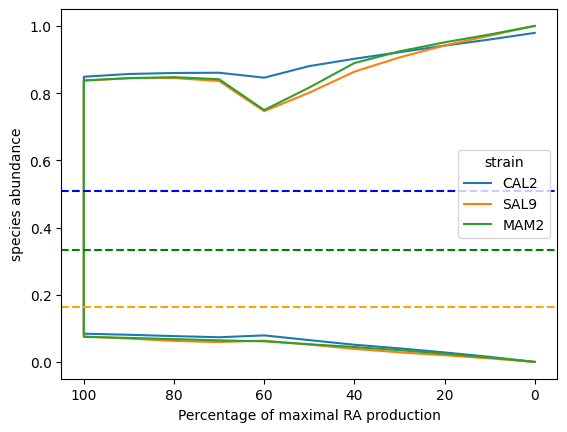

In [14]:
from functions.plot_results import plot_relative_abundance_RA_prod_glc

#this is for obj_frac = 1.0
plot_relative_abundance_RA_prod_glc(results_df, cal2_ra, sal9_ra, mam2_ra)

- solution space is wide and uninteresting

## Model preperation for dfba sim.

adding yield constraints

In [5]:
print(CA_yield, SAA_yield, RA_yield)

0.04483465490800001 0.11514992082541836 0.06003946


In [5]:
### add yield constraints to the models being used for dfba simulation, can use the exp. data, or the calculations from static sim
### before running: set CA_yield, SAA_yield, and RA_yield to correct levels

from cobra.io import read_sbml_model
from functions.modify_GEM import add_ratio_constraint_cobra

# ----- read cobrapy models -----

CAL2_cobra = read_sbml_model("GEMs/CAL2.xml")
SAL9_cobra = read_sbml_model("GEMs/SAL9.xml")
MAM2_cobra = read_sbml_model("GEMs/MAM2.xml")

# ----- add yield ratio constraint -----

# knock out GLCtex_copy1 in all organisms, just so I have one less thing to worry about when flux coupling
CAL2_cobra.reactions.get_by_id("GLCtex_copy1").bounds = (0.0, 0.0)
SAL9_cobra.reactions.get_by_id("GLCtex_copy1").bounds = (0.0, 0.0)
MAM2_cobra.reactions.get_by_id("GLCtex_copy1").bounds = (0.0, 0.0)

add_ratio_constraint_cobra(CAL2_cobra, "34DHCINMt", "GLCtex_copy2", CA_yield);
add_ratio_constraint_cobra(SAL9_cobra, "SAAt", "GLCtex_copy2", SAA_yield);
add_ratio_constraint_cobra(MAM2_cobra, "RAt", "GLCtex_copy2", RA_yield);

### dFBA parameters
Set as arguments to dfba_comets.py functions, or hard-coded in the dfba_comets.py functions.
This is list of parameters that were set according to the experimental conditions, all all other params are default:

- medium
    - initial glucose amount
        - 5 g/L glucose in 0.1 L gives $\frac{5 g/L * 1000 * 0.1 L}{180.156 g/mol}$ = 2.78 mmol glucose
    - phe__L_e
        - added in small concentration so that growth is possible for pheA_KO strains
        - in the experiment yeast-extract is added, so it is difficult to know exact AA amounts
- inocculum
    - using a base-initial pop of 2.e-3 since this seems to correspond best with exp. measurement
    - scaling each individual pop by the ratio they are inoculated at
- running for 500 cycles, with timestep 0.1 h, corresponding to 50 hours
- dilution rate, refresh rate
    - = 0, since there is no addition of medium
- kinetic parameters
    - Km and Vmax for glucose and xylose uptake in *E. coli* are taken from the paper: [Dynamic flux balance modeling of microbial co-cultures for efficient batch fermentation of glucose and xylose mixtures](https://doi.org/10.1002/bit.22954)
- spaceWidth
    - grid size = 4.65 for a single cell that rooms 100 ml

## Dynamic simulation

running simulation with COMETS

In [24]:
from functions.dfba_comets import simulate_glc_triculture

sim = simulate_glc_triculture(CAL2_cobra, SAL9_cobra, MAM2_cobra, initial_pop=2.7e-3, initial_pop_ratio=(2, 3, 1), 
                              adjust_atp_requirements=True, km_glc_adj=1500, glc_vmax_adjustment=0.7)


Running COMETS simulation ...
Done!


### Total biomass

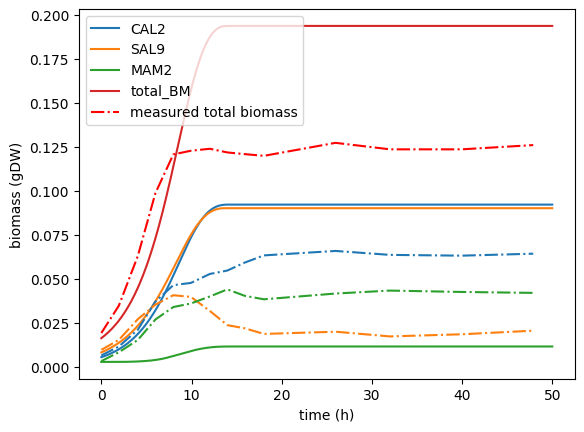

In [25]:
from functions.plot_results import plot_biomass_time_course_glc

plot_biomass_time_course_glc(sim.total_biomass, OD_df, growth_curves=growth_curves)

### Relative species abundance time-course
fig. 7 a

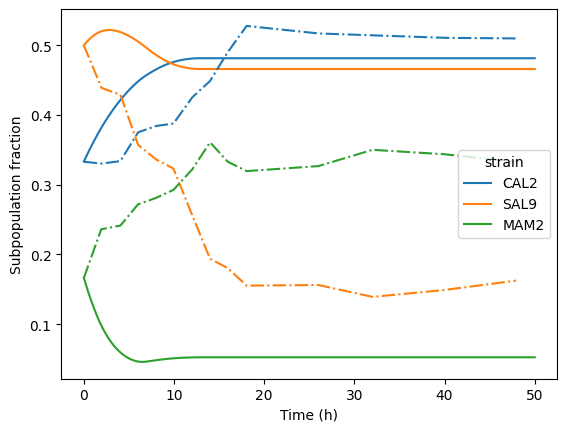

In [18]:
from functions.plot_results import plot_relative_abundance_time_course_glc

plot_relative_abundance_time_course_glc(sim.total_biomass, subpop_df)

### Production of CA, SAA, RA
fig 7. b

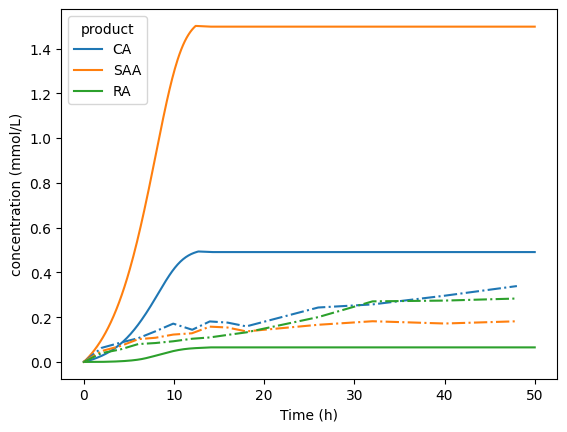

In [19]:
from functions.plot_results import plot_production_time_course

plot_production_time_course(sim.get_metabolite_time_series(), conc_df, double_axis=False)

In [20]:
print("Total biomass g(DW):", sum(sim.total_biomass.drop(columns=["cycle"], inplace=False).iloc[-1]))
print("Total RA produced (mmol): ", sim.get_metabolite_time_series()["rosma_e"].iloc[-1])

Total biomass g(DW): 0.197874834541
Total RA produced (mmol):  0.006495572354


### Fluxes

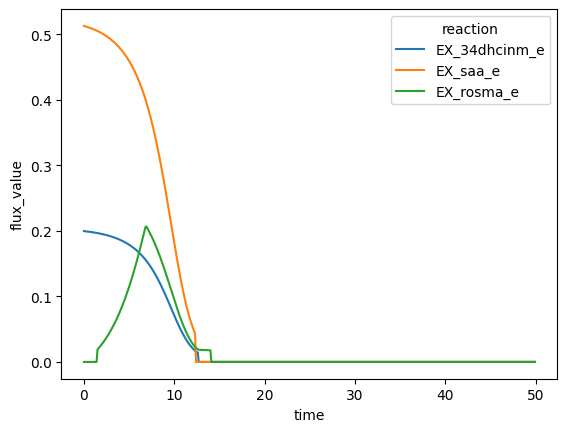

In [21]:
from functions.plot_results import plot_production_flux_values_glc

plot_production_flux_values_glc(sim)

### Metabolites

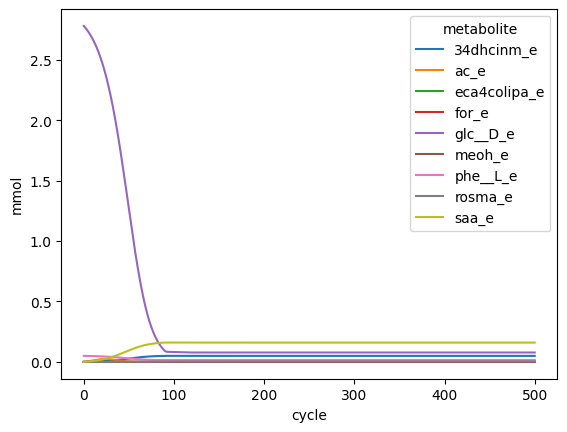

In [16]:
from functions.plot_results import plot_metabolites

plot_metabolites(sim)

### Inoculation ratio
load results from the pairwise comparison (run the program from terminal)

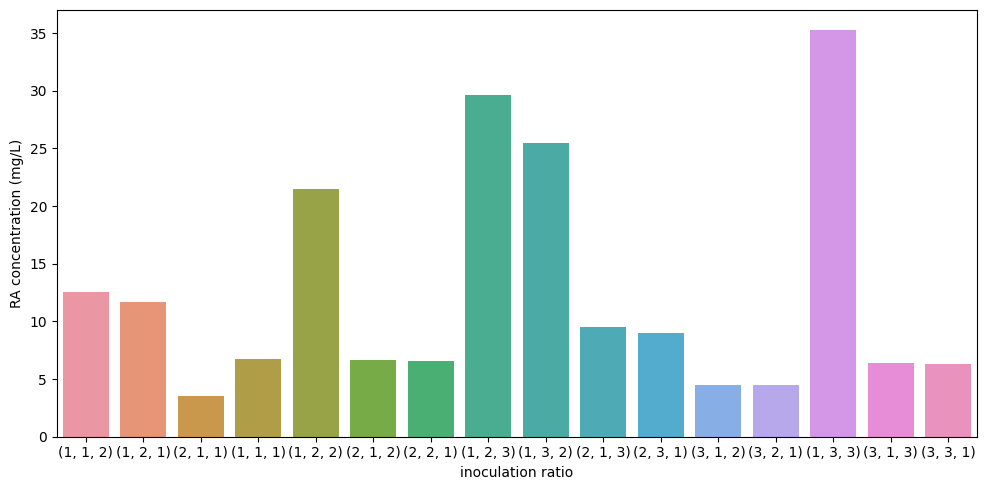

In [92]:
from functions.plot_results import plot_inoculum_4D
import pandas as pd

inoc_results = pd.read_csv("results/fig_4D")

plot_inoculum_4D(inoc_results)